In [1]:
import numpy as np

In [2]:
def goal_func(x):
        return x[:, 0] ** 2 + np.sin(x[:, 1] ** 2) - np.tan(x[:, 2])

In [36]:
def initialize_data(initial_params):  
    x0 = np.array(initial_params)
    steps = [-1, 0, 1]
    X = np.array([x0 + [dx1, dx2, dx3] for dx1 in steps for dx2 in steps for dx3 in steps])
    np.random.shuffle(X)

    D = goal_func(X)
#     D1 = goal_func(X)
#     d1_avg = np.mean(D1)
#     D2 = [1 if d > d1_avg else 0 for d in D1]
#     D = np.array([D1, D2]).T
    return X, D


def get_train_val_data(X, D):
    X_train, X_val = np.array(X)[:20, :], np.array(X)[20:, :]
    D_train, D_val = np.array(D)[:20], np.array(D)[20:]
    return X_train, D_train, X_val, D_val
    
    
X, D = initialize_data([7, 4, 5])
X_train, D_train, X_val, D_val = get_train_val_data(X, D)

In [37]:
print("Train data")
for x, d in zip(X_train, D_train):
    print(f"f{x}={d:<.5f}") #"; f(x) > _avg_: {int(d[1])}")
    
print("\nValidation data")
for x, d in zip(X_val, D_val):
    print(f"f{x}={d:<.5f}") #"; f(x) > _avg_: {int(d[1])}")

Train data
f[6 4 4]=34.55428
f[7 3 4]=48.25430
f[6 4 5]=39.09261
f[7 4 5]=52.09261
f[7 3 5]=52.79263
f[8 5 4]=62.70983
f[7 3 6]=49.70312
f[6 5 4]=34.70983
f[7 4 6]=49.00310
f[8 4 5]=67.09261
f[6 4 6]=36.00310
f[8 4 6]=64.00310
f[6 3 5]=39.79263
f[8 3 4]=63.25430
f[8 3 5]=67.79263
f[8 3 6]=64.70312
f[7 5 4]=47.70983
f[6 5 6]=36.15865
f[8 4 4]=62.55428
f[6 3 6]=36.70312

Validation data
f[7 5 5]=52.24816
f[8 5 5]=67.24816
f[7 5 6]=49.15865
f[6 5 5]=39.24816
f[6 3 4]=35.25430
f[8 5 6]=64.15865
f[7 4 4]=47.55428


In [9]:
from sklearn.preprocessing import MinMaxScaler


# ANFIS (Adaptive – Network – based Fuzzy Inference System)

### (TSK мережа)
[original paper](https://www.researchgate.net/publication/3113825_ANFIS_Adaptive-Network-based_Fuzzy_Inference_System?enrichId=rgreq-0b97adb4133e5b17c0627ec0fb55b2c7-XXX&enrichSource=Y292ZXJQYWdlOzMxMTM4MjU7QVM6MTU5MDc1MDY1MTQ3MzkyQDE0MTQ5Mzc4NTk3MzI%3D&el=1_x_2&_esc=publicationCoverPdf)

<img src="images/TSK/schema.png" width=500 height=500 />

#### Виведення
<img src="images/TSK/method1.png" width=500 height=500 />
<img src="images/TSK/method2.png" width=500 height=500 />
<img src="images/TSK/formula.png" width=500 height=500 />

#### Навчання мережі
<img src="images/TSK/learn1.png" width=500 height=500 />
<img src="images/TSK/learn2.png" width=500 height=500 />
<img src="images/TSK/learn3.png" width=500 height=500 />


In [83]:
class TSK:
    def __init__(self, m=2):
        self.m = m  # number of rules
        self.param = {}
        self.x_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        
    def _initialize(self, n):
        self.param = {
            "L1": {
                "a": np.random.rand(self.m, n), "da": None,
                "b": np.random.rand(self.m, n), "db": None,
                "mu": None,
            },
            "L2": {"w": None},
            "L3": {"p": np.random.rand(self.m, n+1), "dp": None, "g": None},
            "L4": {"f1": None, "f2": None},
            "L5": {"f": None},
        }
    
    def _membership_func(self, x):
        a, b = self.param["L1"]["a"], self.param["L1"]["b"]
        return 1 / (1 + np.exp(b * (x - a)))
    
    def _loss(self, Z, Z0):
        return (Z - Z0) ** 2 / 2
    
    def _feed_forward(self, x):
        # layer1
        self.param["L1"]["mu"] = self._membership_func(x)
        # layer2
        self.param["L2"]["w"] = np.prod(self.param["L1"]["mu"], axis=1)
        # layer3
        p = self.param["L3"]["p"]
        self.param["L3"]["g"] = self.param["L2"]["w"] * (np.dot(p[:,1:], x) + p[:,0]) 
        # layer4
        self.param["L4"]["f1"], self.param["L4"]["f2"] = self.param["L3"]["g"].sum(), self.param["L2"]["w"].sum()
        # layer5
        self.param["L5"]["f"] = self.param["L4"]["f1"] / self.param["L4"]["f2"]
        return self.param["L5"]["f"]
    
    def _backpropagate(self, x, y):
        mu, a, b, w, g, p, f, n = (
            self.param["L1"]["mu"], 
            self.param["L1"]["a"],
            self.param["L1"]["b"],
            self.param["L2"]["w"], 
            self.param["L3"]["g"],
            self.param["L3"]["p"],
            self.param["L5"]["f"],
            len(x),
        )
        diff = f - y
        
        prod_mu = np.prod(mu, axis=1).reshape(self.m, 1)
        diag = np.array([mu[i][i] for i in range(self.m)]).reshape((self.m, 1))
        prod_mu1 = prod_mu / diag
        weighted_sum = (np.dot(p[:,1:], x) + p[:,0]).reshape((self.m, 1))
        helper = weighted_sum * prod_mu1 / prod_mu.sum() - weighted_sum * prod_mu * prod_mu1 / prod_mu.sum() ** 2
        
        self.param["L1"]["da"] = diff * helper * b * np.exp(b * (x - a)) / (1 + np.exp(b * (x - a)))
        self.param["L1"]["db"] = diff * helper * (a - x) * np.exp(b * (x - a)) / (1 + np.exp(b * (x - a)))

        dp0 = diff * prod_mu / prod_mu.sum()
        dp = diff * (x * np.tile(prod_mu, (1, n))) / prod_mu.sum()
        self.param["L3"]["dp"] = np.hstack((dp0, dp))
    
    def _update(self, learning_rate):
        self.param["L1"]["a"] = self.param["L1"]["a"] - learning_rate * self.param["L1"]["da"]
        self.param["L1"]["b"] = self.param["L1"]["b"] - learning_rate * self.param["L1"]["db"]
        self.param["L3"]["p"] = self.param["L3"]["p"] - learning_rate * self.param["L3"]["dp"]
    
    def fit(self, X_train, Y_train, X_val, D_val, learning_rate=0.2, eps=1e-3):
        self._initialize(X_train.shape[1])
        X = self.x_scaler.fit_transform(X_train)
        Y = self.y_scaler.fit_transform(D_train.reshape(-1, 1))
        X_v = self.normalise_x(X_val)
        Y_v = self.normalise_y(D_val)
        i = 0
        losses = []
        val_losses = []
        while True:
            for x, y in zip(X, Y):
                f = self._feed_forward(x)
                self._backpropagate(x, y)
                self._update(learning_rate)

            # check if algorithm should stop
            sum_errors = 0
            for x, y in zip(X, Y):
                f = self._feed_forward(x)
                sum_errors += self._loss(y, f)
            
            losses.append(sum_errors / X.shape[0])
            if sum_errors / X.shape[0] < eps:
                break
                
            # validate
            val_errors = 0
            for x, y in zip(X_v, Y_v):
                f = self._feed_forward(x)
                val_errors += self._loss(y, f)
            val_losses.append(val_errors / X_v.shape[0])
            i += 1
        return i, losses, val_losses
    
    def normalise_x(self, x):
        return self.x_scaler.transform(x)
    
    def normalise_y(self, y):
        if len(y.shape) < 2:
            y = y.reshape((-1, 1))
        return self.y_scaler.transform(y)
    
    def denormalise_x(self, x):
        return self.x_scaler.inverse_transform(x)
    
    def denormalise_y(self, y):
        if len(y.shape) < 2:
            y = y.reshape((-1, 1))
            
        return self.y_scaler.inverse_transform(y)
    
    def predict(self, X):
        X_scaled = self.normalise_x(X)
        Y = [self._feed_forward(x) for x in X_scaled]
        return np.array(Y)

In [84]:
%matplotlib inline

import matplotlib.pyplot as plt

In [90]:
tsk = TSK()
i, losses, val_losses = tsk.fit(X_train, D_train, X_val, D_val)

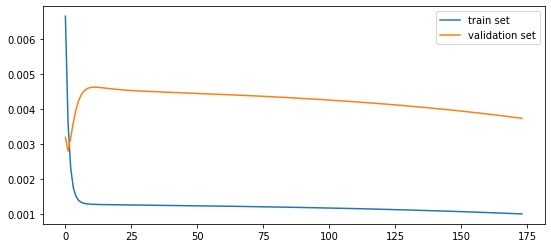

In [91]:
fig, ax = plt.subplots(figsize=(9, 4))
plt.plot(range(i), losses[:-1], label="train set")
plt.plot(range(i), val_losses, label="validation set")
plt.legend()
plt.show()

In [92]:
y_pred = tsk.predict(X_val)
y_pred_denorm = tsk.denormalise_y(y_pred)
# check out on Validation dataset
for x, y, yp, ys, ypd in zip(X_val, D_val, y_pred, tsk.normalise_y(D_val).reshape((-1,)), y_pred_denorm.reshape((-1,))):
    print(
        f"        f({x[0]},{x[1]},{x[2]})\n"
        f"scaled  (Real): {ys:8.5f} <=> {yp:8.5f} (Predicted)\n"
        f"        (Real): {y:8.5f} <=> {ypd:8.5f} (Predicted)\n"
    )


        f(7,5,5)
scaled  (Real):  0.53233 <=>  0.44011 (Predicted)
        (Real): 52.24816 <=> 49.18295 (Predicted)

        f(8,5,5)
scaled  (Real):  0.98362 <=>  0.84838 (Predicted)
        (Real): 67.24816 <=> 62.75316 (Predicted)

        f(7,5,6)
scaled  (Real):  0.43938 <=>  0.39841 (Predicted)
        (Real): 49.15865 <=> 47.79661 (Predicted)

        f(6,5,5)
scaled  (Real):  0.14122 <=>  0.03281 (Predicted)
        (Real): 39.24816 <=> 35.64478 (Predicted)

        f(6,3,4)
scaled  (Real):  0.02106 <=>  0.02732 (Predicted)
        (Real): 35.25430 <=> 35.46224 (Predicted)

        f(8,5,6)
scaled  (Real):  0.89067 <=>  0.80066 (Predicted)
        (Real): 64.15865 <=> 61.16700 (Predicted)

        f(7,4,4)
scaled  (Real):  0.39111 <=>  0.45328 (Predicted)
        (Real): 47.55428 <=> 49.62069 (Predicted)

